# Task description

- Find routes where people went fast from station to station
- compare all data vs fast journeys:
    - Check distribution of bike types, membership
    - Check month and weekday distributions

# Init and define constants

In [99]:
import pandas as pd
import folium
import os
import networkx as nx
import osmnx as ox
import numpy as np

MEAN_LAT = 41.90234770710154
MEAN_LNG = -87.64440345010253
BIKE_SPEED = 20 # km/h
MIN_STATION_COUNT = 100
MIN_PAIR_COUNT = 20

# The 5th and 95th percentiles of latitude and longitude from all data
MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT = (-87.7, 41.8, -87.6, 41.96909)

DATA_DIR = 'bike_rent'
FILES = os.listdir(DATA_DIR)

GRAPH_FILE = "all_public_percentile_bbox.graphml"

In [ ]:
# Load and save graph to be loaded later
GRAPH_FILE = "all_public_percentile_bbox.graphml"
# Load the graph from bbox
bbox = (MIN_LNG, MIN_LAT, MAX_LNG, MAX_LAT)
G = ox.graph_from_bbox(bbox, network_type="all_public")
# assign speeds constant speed to all edges
nx.set_edge_attributes(G, values=BIKE_SPEED, name="speed_kph")
# convert length+speed → seconds
G = ox.add_edge_travel_times(G)
# save the graph to a file
ox.save_graphml(G, GRAPH_FILE)

In [3]:
# None -> graph
def load_graph():
    G = ox.load_graphml(GRAPH_FILE)
    return G

G = load_graph()
# Load the graph once in the main process
# The other processses will copy

# Sequential functions

In [4]:
# start_lat, start_lng, end_lat, end_lng -> float
def calculate_distance(lat1, lon1, lat2, lon2):
    R = 6378
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(lat1) * np.cos(lat2) * np.sin(
        dlon / 2
    ) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# start_lat, start_lng, end_lat, end_lng, duration -> bool
def this_is_fast_enough(start_lat, start_lng, end_lat, end_lng, duration):
    # Get the manhattan distance in km
    dist1 = calculate_distance(start_lat, start_lng, end_lat, start_lng)
    dist2 = calculate_distance(end_lat, start_lng, end_lat, end_lng)
    manhattan_distance = dist1 + dist2
    # Calculate how much it takes with the bike speed
    maximum_fast_ride_duration = (manhattan_distance / BIKE_SPEED) * 3600  # in seconds
    return maximum_fast_ride_duration * 1.5 > duration  # less than the maximum fast ride duration


# DataFrame -> DataFrame
def filter_and_prepare_data(df):
    # Remove rows with NA in start_station_id or end_station_id
    df = df.dropna(subset=['start_station_id', 'end_station_id']).reset_index(drop=True)
    
    # Convert the 'started_at' and 'ended_at' columns to datetime
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    
    # Calculate duration in seconds
    df['duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()
    
    # Filter by duration, keeping trips from 1 minute to 1 hour
    df = df[(df['duration'] >= 60) & (df['duration'] <= 3600)].reset_index(drop=True)

    if len(df) == 0:
        return df
     # apply this is fast enough
    df['is_fast_enough'] = df.apply(
        lambda row: this_is_fast_enough(
            row['start_lat'], row['start_lng'], 
            row['end_lat'], row['end_lng'], 
            row['duration']
        ), axis=1
    )
    df = df[df.is_fast_enough].reset_index(drop=True)

    station_counts = pd.concat([df.start_station_id, df.end_station_id]).value_counts()
    station_counts = station_counts[station_counts > MIN_STATION_COUNT]
    df = df[df.start_station_id.isin(station_counts.index) & df.end_station_id.isin(station_counts.index)]
    df=df.reset_index(drop=True)
    
    return df

# DataFrame -> dict
def get_stats(df):
    if len(df) == 0:
        return {
            'bike_counts': {},
            'member_counts': {},
            'daily_counts': {}
        }
    bike_counts = df.rideable_type.value_counts().to_dict()
    member_counts = df.member_casual.value_counts().to_dict()
    daily_counts = df['started_at'].dt.date.value_counts().sort_index().to_dict()

    stats = {
        'bike_counts': bike_counts,
        'member_counts': member_counts,
        'daily_counts': daily_counts
    }

    return stats

# list[dict] -> dict
def join_stats(stats):
    """
    Join multiple stats dictionaries into one.
    """
    joined_stats = {
        'bike_counts': {},
        'member_counts': {},
        'daily_counts': {}
    }

    for stat in stats:
        for key in joined_stats.keys():
            for k, v in stat[key].items():
                if k in joined_stats[key]:
                    joined_stats[key][k] += v
                else:
                    joined_stats[key][k] = v

    return joined_stats

# DataFrame, station_dict -> station_dict
def get_station_coordinates(df, station_coords):

    # Extract start and end station coordinates to one DataFrame
    start_coords = df[['start_station_id', 'start_lat', 'start_lng']]
    end_coords = df[['end_station_id', 'end_lat', 'end_lng']]
    start_coords = start_coords.rename(columns={
        'start_station_id': 'station_id',
        'start_lat': 'latitude',
        'start_lng': 'longitude'
    })
    end_coords = end_coords.rename(columns={
        'end_station_id': 'station_id',
        'end_lat': 'latitude',
        'end_lng': 'longitude'
    })
    all_coords = pd.concat([start_coords, end_coords])

    # Remove existing stations from the DataFrame
    all_coords = all_coords[~ all_coords.station_id.isin(station_coords.keys())]
    
    # Calculate the median coordinates for each station
    all_coords = all_coords.groupby('station_id').median().reset_index()
    new_station_coords = all_coords.set_index('station_id').T.to_dict('list')
    
    # Concate dictionaries
    station_coords.update(new_station_coords)
    return station_coords

# DataFrame -> list[tuple]
def get_trip_pairs(df):
    def sort_pair(row):
        return tuple(sorted([row['start_station_id'], row['end_station_id']]))
    df['pair'] = df.apply(sort_pair, axis=1)

    pair_counts = df["pair"].value_counts()
    pair_counts = pair_counts[pair_counts > MIN_PAIR_COUNT]
    return pair_counts.index

# Graph, start_lat, start_lng, end_lat, end_lng -> float
def calculate_fastest_travel_time(G, start_lat, start_lng, end_lat, end_lng):
    # In the graph, get the nodes closest to the points
    origin_node = ox.nearest_nodes(G, Y=start_lat, X=start_lng)
    destination_node = ox.nearest_nodes(G, Y=end_lat, X=end_lng)

    # compute travel time in seconds
    try:
        travel_time_in_seconds = nx.shortest_path_length(G, origin_node, destination_node, weight='travel_time')
    except nx.NetworkXNoPath:
        print(f"No path found from ({start_lat}, {start_lng}) to ({end_lat}, {end_lng})")
        return -1
    
    return travel_time_in_seconds

# Paralel workers

In [5]:
"""
‣ One reader process:
    - reads CSV files,
    - filters and prepares data,
    - adds new “station” coordinates,
    - emits <start,end> pairs.

‣ N worker processes:
    - pull pairs, look up / cache a distance, calculate the fastest travel time,
    - store results in a shared list.

Shared counters give the dashboard:
    Files 1/3 | Queue 14 | Waiting 2/3 | Processed 26
"""

import multiprocessing as mp
import time
from queue import Empty          # non-blocking Queue ops

# ───────────────────────── helpers ──────────────────────────────
def inc(val, n=1):               # atomic += n for a mp.Value
    with val.get_lock():
        val.value += n

# ──────────────────────── producer ──────────────────────────────
def data_reader(queue,
                station_coords, lock,
                files, data_dir,
                items_in_q, files_done):
    for file in files:
        df = pd.read_csv(f'{data_dir}/{file}')
        df = filter_and_prepare_data(df)
        
        # Get new station coordinates
        with lock:
            station_coords = get_station_coordinates(df, station_coords)

        # Get trip pairs
        trip_pairs = get_trip_pairs(df)

        # emit trip pairs
        for a, b in trip_pairs:
            queue.put((a, b))
            inc(items_in_q)

        inc(files_done)              # one file done

    queue.put((None, None))          # poison pill

# ──────────────────────── consumer ─────────────────────────────
def distance_worker(wid, queue,
                    G_main,
                    station_coords, distance_cache, results, lock,
                    items_in_q, items_done, workers_waiting):
    processed = calculated = 0

    # No need to load the graph in each worker, just pass it
    G = G_main.copy()
    
    while True:
        try:
            inc(workers_waiting)     # going to block
            a, b = queue.get(timeout=1)
            inc(workers_waiting, -1)
        except Empty:                # nothing to do
            inc(workers_waiting, -1)
            continue

        if a is None:                # shutdown signal
            queue.put((None, None))
            break

        key = (a, b)
        cached = True
        inc(workers_waiting)
        with lock:                   # cache lookup / insert
            inc(workers_waiting, -1)
            if key not in distance_cache:
                start_lan, start_lon = station_coords[a]
                end_lan, end_lon = station_coords[b]
                cached = False

        if not cached:
            fastest_time = calculate_fastest_travel_time(G, start_lan, start_lon, end_lan, end_lon)
            with lock:               # cache insert
                distance_cache[key] = fastest_time
            calculated += 1

        processed += 1
        inc(items_in_q, -1)
        inc(items_done)

    with lock:
        results.append(dict(worker=wid,
                            processed=processed,
                            calculated=calculated))

# ────────────────── tiny dashboard in parent ───────────────────
def monitor(total_files, nworkers,
            files_done, items_in_q, workers_waiting, items_done,
            procs):
    start_time = time.perf_counter()
    while any(p.is_alive() for p in procs):
        ctime = time.perf_counter()
        elapsed = ctime - start_time
        print(f"\rFiles {files_done.value}/{total_files} | "
              f"Queue {items_in_q.value} | "
              f"Waiting {workers_waiting.value}/{nworkers} | "
              f"Processed {items_done.value} | "
              f"Elapsed {elapsed:.1f}s",
              end="", flush=True)
        time.sleep(0.2)
    print()                          # newline when finished

# Start the main process

In [ ]:
# ──────────────────────── bootstrap ────────────────────────────
NWORKERS = 5

queue = mp.Queue()
manager = mp.Manager()
station_coords = manager.dict()    # station_id → coord
distance_cache = manager.dict()    # (a,b)     → dist
results        = manager.list()
lock           = manager.Lock()

# shared dashboard counters
files_done      = mp.Value('i', 0)
items_in_q      = mp.Value('i', 0)
items_done      = mp.Value('i', 0)
workers_waiting = mp.Value('i', 0)

reader = mp.Process(target=data_reader,
                  args=(queue, station_coords, lock,
                        FILES, DATA_DIR,
                        items_in_q, files_done))

workers = [mp.Process(target=distance_worker,
                        args=(wid, queue,
                              G, station_coords, distance_cache, 
                              results, lock,
                              items_in_q, items_done, workers_waiting))
            for wid in range(NWORKERS)]

procs = [reader, *workers]
for p in procs: p.start()

monitor(len(FILES), NWORKERS,
      files_done, items_in_q, workers_waiting, items_done,
      procs)

for p in procs: p.join()

print("\nPer-worker stats:", list(results))
print("Cached distances :", len(distance_cache))


Files 3/3 | Queue 0 | Waiting 0/5 | Processed 793 | Elapsed 201.8sss

Per-worker stats: [{'worker': 1, 'processed': 171, 'calculated': 123}, {'worker': 0, 'processed': 164, 'calculated': 124}, {'worker': 2, 'processed': 164, 'calculated': 126}, {'worker': 3, 'processed': 149, 'calculated': 123}, {'worker': 4, 'processed': 145, 'calculated': 124}]
Cached distances : 620


# Check progress stats

In [11]:
import pandas as pd
workers_results = pd.DataFrame(list(results)).sort_values("worker")
workers_results

,worker,processed,calculated
1,0,164,124
0,1,171,123
2,2,164,126
3,3,149,123
4,4,145,124


In [12]:
# Analyze results
print(f"\n📊 Results Summary:")
print(f"Stations in lookup table: {len(station_coords)}")
print(f"Cached routes: {len(distance_cache)}")

# Worker statistics from the new format
total_processed = workers_results['processed'].sum()
total_calculated = workers_results['calculated'].sum()
cached_count = total_processed - total_calculated

if total_processed > 0:
    print(f"Total items processed: {total_processed}")
    print(f"Calculated (new): {total_calculated}")
    print(f"Cached (reused): {cached_count}")
    print(f"Cache hit rate: {cached_count/total_processed*100:.1f}%")

# Show worker performance
print(f"\n👥 Worker Performance:")
for result in workers_results.to_dict('records'):
    worker_id = result['worker']
    processed = result['processed']
    calculated = result['calculated']
    cached = processed - calculated
    print(f"  Worker {worker_id}: {processed} total ({calculated} calculated, {cached} cached)")

# Show sample cache entries
print(f"\n🗂️ Sample cached routes:")
for i, (route, distance) in enumerate(list(distance_cache.items())[:3]):
    start, end = route
    print(f"  Route {start}→{end}: Distance = {distance:.2f}")


📊 Results Summary:
Stations in lookup table: 355
Cached routes: 620
Total items processed: 793
Calculated (new): 620
Cached (reused): 173
Cache hit rate: 21.8%

👥 Worker Performance:
  Worker 0: 164 total (124 calculated, 40 cached)
  Worker 1: 171 total (123 calculated, 48 cached)
  Worker 2: 164 total (126 calculated, 38 cached)
  Worker 3: 149 total (123 calculated, 26 cached)
  Worker 4: 145 total (124 calculated, 21 cached)

🗂️ Sample cached routes:
  Route 13063→TA1307000150: Distance = 188.74
  Route 13325→13389: Distance = 245.87
  Route KA1503000014→KA1504000076: Distance = 0.00


In [13]:
# save the station coordinates to a file with pickle
import pickle

with open('results/station_coordinates.pkl', 'wb') as f:
    pickle.dump(dict(station_coords), f)

# save the distance cache to a file with pickle
with open('results/distance_cache.pkl', 'wb') as f:
    pickle.dump(dict(distance_cache), f)

# Save the results to a CSV file
workers_results.to_csv('results/workers_results.csv', index=False)

# Process the results and stats

In [96]:
# Load
import pickle 
import pandas as pd

with open('results_final/station_coordinates.pkl', 'rb') as f:
    station_coords = pickle.load(f)
with open('results_final/distance_cache.pkl', 'rb') as f:
    distance_cache = pickle.load(f)
workers_results = pd.read_csv('results_final/workers_results.csv')

In [97]:
fast_distance_df = pd.Series(distance_cache).rename("fast_duration").reset_index()
def sort_pair_fast_distance(row):
    return tuple(sorted([row['level_0'], row['level_1']]))
fast_distance_df['pair'] = fast_distance_df.apply(sort_pair_fast_distance, axis=1)
fast_distance_df = fast_distance_df.drop(columns=['level_0', 'level_1'])

In [100]:
from tqdm import tqdm
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor

# Get stats for the filtered data

def process_file(file):
    """Process a single file and return stats and filtered data"""
    df = pd.read_csv(f'{DATA_DIR}/{file}')
    df = filter_and_prepare_data(df)
    
    # Get stats for all filtered data
    current_stats = get_stats(df)
    
    # Create pair column for joining with fast distance data
    def sort_pair(row):
        return tuple(sorted([row['start_station_id'], row['end_station_id']]))
    df['pair'] = df.apply(sort_pair, axis=1)
    
    # Join with fast distance
    df = df.merge(fast_distance_df, on='pair', how='left')
    
    # Filter by fast duration (only keep routes that are fast enough)
    df = df[df.fast_duration > 0].reset_index(drop=True)
    df = df[df['duration'] <= df['fast_duration'] * 1.1].reset_index(drop=True)
    
    # Get stats for fast rides
    current_fast_stats = get_stats(df)
    
    return current_stats, current_fast_stats, df

# Use ProcessPoolExecutor to parallelize file processing
all_stats = []
fast_stats = []
all_fast_dfs = []

# Number of CPUs to use (adjust based on your machine)
n_cpus = min(mp.cpu_count(), len(FILES))
print(f"Processing {len(FILES)} files using {n_cpus} workers")

with ProcessPoolExecutor(max_workers=n_cpus) as executor:
    results = list(tqdm(executor.map(process_file, FILES), total=len(FILES)))
    
# Unpack results
for current_stats, current_fast_stats, df in results:
    all_stats.append(current_stats)
    fast_stats.append(current_fast_stats)
    all_fast_dfs.append(df)

Processing 12 files using 12 workers


100%|██████████| 12/12 [00:37<00:00,  3.15s/it]


In [101]:
fast_df = pd.concat(all_fast_dfs, ignore_index=True)

In [102]:
all_ride_stats = join_stats(all_stats)
fast_ride_stats = join_stats(fast_stats)

In [103]:
# Create a table of bike types and their counts.
# One column for each type, one row for all rides / fast rides
bike_types = list(all_ride_stats['bike_counts'].keys())
bike_counts = {
    'All Rides': [all_ride_stats['bike_counts'].get(bike_type, 0) for bike_type in bike_types],
    'Fast Rides': [fast_ride_stats['bike_counts'].get(bike_type, 0) for bike_type in bike_types]
}
bike_counts_df = pd.DataFrame(bike_counts, index=bike_types)
bike_counts_df["percentage_fast"] = bike_counts_df['Fast Rides'] / bike_counts_df['All Rides'] * 100
bike_counts_df

,All Rides,Fast Rides,percentage_fast
classic_bike,1123365,29511,2.627018
electric_bike,596651,88695,14.865474
docked_bike,31024,326,1.050799


In [104]:
# Create a table of member types and their counts.
member_types = list(all_ride_stats['member_counts'].keys())
member_counts = {
    'All Rides': [all_ride_stats['member_counts'].get(member_type, 0) for member_type in member_types],
    'Fast Rides': [fast_ride_stats['member_counts'].get(member_type, 0) for member_type in member_types]
}
member_counts_df = pd.DataFrame(member_counts, index=member_types)
member_counts_df["percentage_fast"] = member_counts_df['Fast Rides'] / member_counts_df['All Rides'] * 100
member_counts_df

,All Rides,Fast Rides,percentage_fast
member,1204275,90779,7.538062
casual,546765,27753,5.075855


In [105]:
date_count_df = pd.DataFrame(
    all_ride_stats["daily_counts"].items(),
    columns=["date", "all_rides"]
)
date_count_df_fast = pd.DataFrame(
    fast_ride_stats["daily_counts"].items(),
    columns=["date", "fast_rides"]
)
# Merge the two DataFrames on the 'date' column
date_count_df = pd.merge(date_count_df, date_count_df_fast, on='date', how='outer')

# Aggregate per mont date_count_df
date_count_df['date'] = pd.to_datetime(date_count_df['date'])
date_count_df['month'] = date_count_df['date'].dt.to_period('M')
date_count_month_df = date_count_df.groupby('month')[["all_rides", "fast_rides"]].sum().astype(int)

date_count_month_df["percentage_fast"] = ((
    date_count_month_df["fast_rides"] / date_count_month_df["all_rides"]
) * 100).round(2)
date_count_month_df

,all_rides,fast_rides,percentage_fast
month,,,
2021-01,33112,2185,6.60
2021-02,5951,254,4.27
2021-03,77867,4561,5.86
2021-04,112931,6336,5.61
2021-05,157816,8334,5.28
2021-06,215967,11691,5.41
2021-07,246003,14177,5.76
2021-08,248006,14698,5.93
2021-09,242216,14681,6.06


In [107]:

# Aggregate per day of the week
date_count_df['day_of_week'] = date_count_df['date'].dt.day_name()
date_count_weekday_df = date_count_df.groupby('day_of_week')[["all_rides", "fast_rides"]].sum()
# Sort the days of the week
date_count_weekday_df = date_count_weekday_df.T[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].T.astype(int)

date_count_weekday_df["percentage_fast"] = ((
    date_count_weekday_df["fast_rides"] / date_count_weekday_df["all_rides"]
) * 100).round(2)
date_count_weekday_df

,all_rides,fast_rides,percentage_fast
day_of_week,,,
Monday,231290,17650,7.63
Tuesday,263284,19923,7.57
Wednesday,270499,19768,7.31
Thursday,259312,18700,7.21
Friday,253409,17210,6.79
Saturday,255348,13403,5.25
Sunday,217898,11878,5.45


# Draw a map with the stations

In [171]:
m = folium.Map(location=[MEAN_LAT, MEAN_LNG], zoom_start=11)

def coords_to_path(start_lat, start_lng, end_lat, end_lng):
    """
    Convert start and end coordinates to a path of coordinates.
    """
    # snap start/end points to nearest nodes
    orig = ox.nearest_nodes(G, start_lng, start_lat)
    dest = ox.nearest_nodes(G, end_lng, end_lat)

    # shortest path by distance
    try:
        path_nodes = nx.shortest_path(G, orig, dest, weight="travel_time")
    except nx.NetworkXNoPath:
        print(f"No path found between {orig} and {dest}.")
        return []
    path_coords = [(G.nodes[n]['y'], G.nodes[n]['x']) for n in path_nodes]
    
    return path_coords

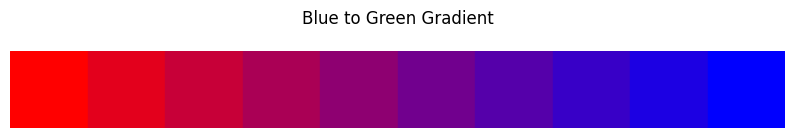

In [172]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_hex

def bright_red_to_blue_gradient(number_of_colors):
    cmap = LinearSegmentedColormap.from_list("red_blue", ["red", "blue"])
    return [to_hex(cmap(i / (number_of_colors - 1))) for i in range(number_of_colors)]


# Example usage and visualization
number_of_colors = 10
colors = bright_red_to_blue_gradient(number_of_colors)

plt.figure(figsize=(number_of_colors, 1))
for i, color in enumerate(colors):
    plt.axvspan(i, i+1, color=color)
plt.xlim(0, number_of_colors)
plt.axis('off')
plt.title('Blue to Green Gradient', pad=20)
plt.show()


In [173]:
routes_to_draw = 50
route_i = 0
colors = bright_red_to_blue_gradient(routes_to_draw)

for (a, b), fast_count in fast_df.pair.value_counts().head(routes_to_draw).items():
    # get the coords and path
    start_lat, start_lng = station_coords[a]
    end_lat, end_lng = station_coords[b]
    path_coords = coords_to_path(start_lat, start_lng, end_lat, end_lng)
    # plot to the map
    # Include the fast_count in the popup
    if len(path_coords) > 0:
        folium.PolyLine(
            path_coords,
            color=colors[route_i],
            weight=5,
            popup=f"{fast_count} fast rides)"
        ).add_to(m)

    route_i += 1

In [174]:
m

# Draw speedup graph

In [112]:
# speedup_results.json is generated bu script speedup.py
import json
with open('results_final/speedup_results.json', 'r') as f:
    durations = json.load(f)
nworkers = [1, 2, 4, 8, 16, 32]
durations

[331.2423484348692,
 172.71971855917946,
 97.41670867078938,
 55.00903439009562,
 33.94990255800076,
 28.405511616030708]

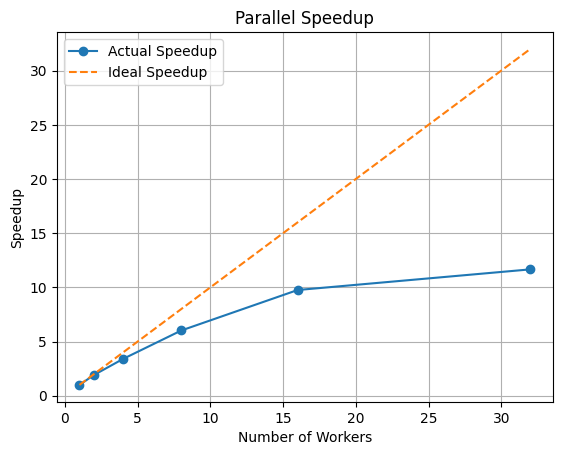

In [119]:
import matplotlib.pyplot as plt

# Speedup: T1 / Tn
speedup = [durations[0] / t for t in durations]

# Plot
plt.figure()
plt.plot(nworkers, speedup, marker='o', label='Actual Speedup')
plt.plot(nworkers, nworkers, linestyle='--', label='Ideal Speedup')
plt.xlabel('Number of Workers')
plt.ylabel('Speedup')
plt.title('Parallel Speedup')
plt.legend()
plt.grid(True)
plt.show()

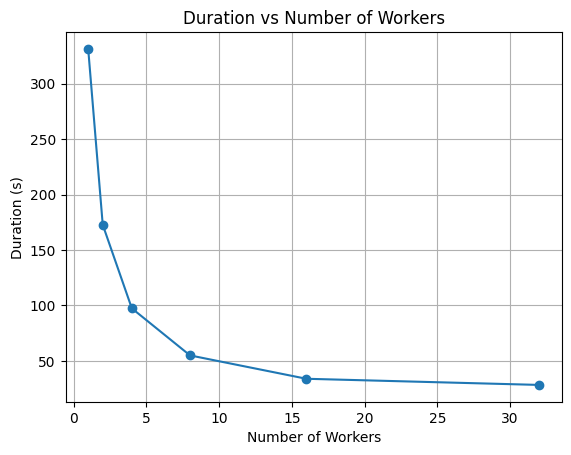

In [ ]:
plt.figure()
plt.plot(nworkers, durations, marker='o')
plt.xlabel('Number of Workers')
plt.ylabel('Duration (s)')
plt.title('Duration vs Number of Workers')
plt.grid(True)
plt.show()